In [42]:
! pip install livelossplot

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

from livelossplot import PlotLossesKeras


In [44]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, precision_recall_curve

def plot_confusion_matrix(model, X_test, y_test, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    y_predict = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predict)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    classes = np.arange(len(model.classes_))
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def print_roc(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    plot_roc_curve(clf, X_test, y_test)
    plt.plot([(0,0),(1,1)], '--y')
    plt.title('ROC curve')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()

# Data cleaning

In [45]:
df = pd.read_csv('KaggleV2-May-2016.csv')
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

## Encoding

In [46]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [47]:
df_t = pd.DataFrame()

le_1 = LabelEncoder()
df_t['Gender'] = pd.Series(le_1.fit_transform(df['Gender']), index=df.index)
df_t['Age'] = df['Age']
df_t['Age'] = pd.Series(le_1.fit_transform(df['Age']), index=df.index)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df_t['ScheduledDay'] = df['ScheduledDay'].dt.weekday
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')
df_t['AppointmentDay'] = df['AppointmentDay'].dt.weekday
df_t['wait_time'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days
df_t['Scholarship'] = df['Scholarship']
df_t['Hypertension'] = df['Hypertension']
df_t['Diabetes'] = df['Diabetes']
df_t['Alcoholism'] = df['Alcoholism']
df_t['Handicap'] = df['Handicap']

enc_1 = OneHotEncoder(handle_unknown='ignore')

enc_1.fit(df['Neighbourhood'].to_numpy().reshape(-1,1))
enc_arr = enc_1.transform(df['Neighbourhood'].to_numpy().reshape(-1,1)).toarray()
Neighbourhoods = enc_1.get_feature_names()
df_Neighbourhoods = pd.DataFrame(data=enc_arr, columns=enc_1.get_feature_names(),
                                 index=df.index)

df_t = pd.concat([df_t, df_Neighbourhoods], axis=1)

le_2 = LabelEncoder()
df_t['NoShow'] = le_2.fit_transform(df['NoShow'])

In [48]:
for feature in df_t.columns:
    df_t[feature] = df_t[feature].astype('int')

df_t.head()

,Gender,Age,ScheduledDay,AppointmentDay,wait_time,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,x0_AEROPORTO,x0_ANDORINHAS,x0_ANTÔNIO HONÓRIO,x0_ARIOVALDO FAVALESSA,x0_BARRO VERMELHO,x0_BELA VISTA,x0_BENTO FERREIRA,x0_BOA VISTA,x0_BONFIM,x0_CARATOÍRA,x0_CENTRO,x0_COMDUSA,x0_CONQUISTA,x0_CONSOLAÇÃO,x0_CRUZAMENTO,x0_DA PENHA,x0_DE LOURDES,x0_DO CABRAL,x0_DO MOSCOSO,x0_DO QUADRO,x0_ENSEADA DO SUÁ,x0_ESTRELINHA,x0_FONTE GRANDE,x0_FORTE SÃO JOÃO,x0_FRADINHOS,x0_GOIABEIRAS,x0_GRANDE VITÓRIA,x0_GURIGICA,x0_HORTO,x0_ILHA DAS CAIEIRAS,...,x0_JUCUTUQUARA,x0_MARIA ORTIZ,x0_MARUÍPE,x0_MATA DA PRAIA,x0_MONTE BELO,x0_MORADA DE CAMBURI,x0_MÁRIO CYPRESTE,x0_NAZARETH,x0_NOVA PALESTINA,x0_PARQUE INDUSTRIAL,x0_PARQUE MOSCOSO,x0_PIEDADE,x0_PONTAL DE CAMBURI,x0_PRAIA DO CANTO,x0_PRAIA DO SUÁ,x0_REDENÇÃO,x0_REPÚBLICA,x0_RESISTÊNCIA,x0_ROMÃO,x0_SANTA CECÍLIA,x0_SANTA CLARA,x0_SANTA HELENA,x0_SANTA LUÍZA,x0_SANTA LÚCIA,x0_SANTA MARTHA,x0_SANTA TEREZA,x0_SANTO ANDRÉ,x0_SANTO ANTÔNIO,x0_SANTOS DUMONT,x0_SANTOS REIS,x0_SEGURANÇA DO LAR,x0_SOLON BORGES,x0_SÃO BENEDITO,x0_SÃO CRISTÓVÃO,x0_SÃO JOSÉ,x0_SÃO PEDRO,x0_TABUAZEIRO,x0_UNIVERSITÁRIO,x0_VILA RUBIM,NoShow
0,0,63,4,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,57,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,63,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,9,4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,57,4,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Model Building

## DNN

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [50]:
df_t.shape

(110527, 92)

91 Input features -- 
1 prediction

### Feature pre-prossesing

In [51]:
X = df_t.drop(['NoShow'], axis=1)
y = df_t['NoShow']

In [52]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(X.min(axis=0))
print(X.max(axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [53]:
import pickle

encoders = [le_1, enc_1, scaler]

with open('encoders.pickle', 'wb') as handle:
    pickle.dump(encoders, handle, protocol=4)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [55]:
layers = []
layers.append(Dense(128, input_dim=91, activation='relu', name='fc_1')) # 1st fully connected layer
layers.append(Dense(64, activation='sigmoid', name='fc_2')) # 2nd connected layer
layers.append(Dropout(0.5, name='drop_out'))
layers.append(Dense(1, activation='sigmoid', name='fc_3')) # 3rd fully connected layer
model = Sequential(layers, name='show/no_show')

In [56]:
model.compile(
    optimizer='adam', 
    loss='mse', 
    metrics=['accuracy'])#, 'AUC'])

In [57]:
print(f'input shape: {model.input_shape[1]}')
print(f'out shape: {model.output_shape[1]}\n\n')

model.summary()

input shape: 91
out shape: 1


Model: "show/no_show"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_1 (Dense)                 (None, 128)               11776     
_________________________________________________________________
fc_2 (Dense)                 (None, 64)                8256      
_________________________________________________________________
drop_out (Dropout)           (None, 64)                0         
_________________________________________________________________
fc_3 (Dense)                 (None, 1)                 65        
Total params: 20,097
Trainable params: 20,097
Non-trainable params: 0
_________________________________________________________________


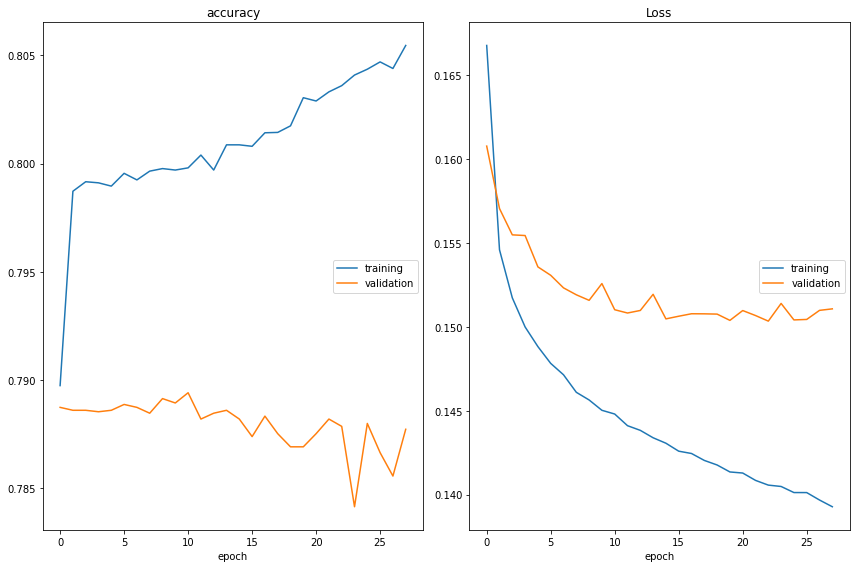

accuracy
	training         	 (min:    0.790, max:    0.805, cur:    0.805)
	validation       	 (min:    0.784, max:    0.789, cur:    0.788)
Loss
	training         	 (min:    0.139, max:    0.167, cur:    0.139)
	validation       	 (min:    0.150, max:    0.161, cur:    0.151)


In [58]:
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0,
                   mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(x=X_train, y=y_train, validation_split=0.2,
                    epochs=100, batch_size=50, verbose=-1,
                    callbacks=[PlotLossesKeras(), es])

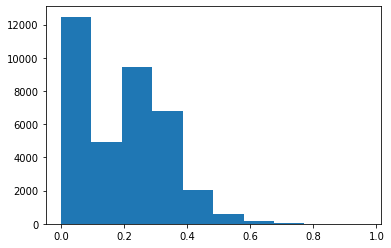

In [59]:
y_pred = model.predict(X_test)
plt.hist(y_pred);

In [60]:
y_pred.mean(), y_test.mean()

(0.19310161, 0.20011515051817733)

In [61]:
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

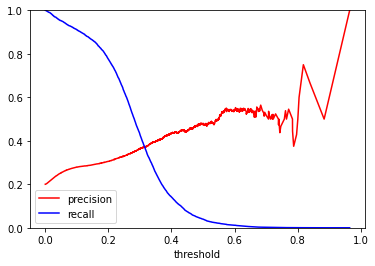

In [62]:
plt.plot(threshold, precision[:-1], "r", label="precision")
plt.plot(threshold, recall[:-1], "b", label="recall")
plt.xlabel("threshold")
plt.legend()
plt.ylim([0, 1])
plt.show()

In [63]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [64]:
! zip -r model.zip model

updating: model/ (stored 0%)
updating: model/variables/ (stored 0%)
updating: model/variables/variables.index (deflated 62%)
updating: model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: model/saved_model.pb (deflated 87%)
updating: model/assets/ (stored 0%)
